<a href="https://colab.research.google.com/github/FeliGR/Madrid-Mortality-Forecast-Climate-Time-Series/blob/main/madrid_mortality_forecast_with_climate_exogenous_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skforecast

## **1. Carga y Preparación de los Datos**
A continuación, cargamos los datos y verificamos la estructura, tipos de datos, y la existencia de valores faltantes.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Cargar los datos
defunciones_temperaturas_madrid_df = pd.read_csv('defunciones_temperaturas_madrid.csv')

In [4]:
# Visualizar las primeras filas para verificar la estructura
print(defunciones_temperaturas_madrid_df.head())

        fecha  defunciones_corregidas  tavg  tmin  tmax
0  2015-01-01                  148.74   5.9  -1.0  10.4
1  2015-01-02                  159.11   7.6  -1.0  12.0
2  2015-01-03                  161.42   7.7   1.2  11.4
3  2015-01-04                  140.67  10.1   1.4  14.0
4  2015-01-05                  181.02   7.7   1.5  12.0


In [5]:
# Verificar los tipos de datos
print(defunciones_temperaturas_madrid_df.dtypes)

fecha                      object
defunciones_corregidas    float64
tavg                      float64
tmin                      float64
tmax                      float64
dtype: object


In [6]:
# Convertir la columna de fecha al formato datetime
defunciones_temperaturas_madrid_df['fecha'] = pd.to_datetime(defunciones_temperaturas_madrid_df['fecha'], errors='coerce')

# Establecer la columna de fecha como índice
defunciones_temperaturas_madrid_df.set_index('fecha', inplace=True)

defunciones_temperaturas_madrid_df = defunciones_temperaturas_madrid_df.asfreq('D')

In [7]:
# Mostrar las primeras filas después del ajuste de fecha
print(defunciones_temperaturas_madrid_df.head())

            defunciones_corregidas  tavg  tmin  tmax
fecha                                               
2015-01-01                  148.74   5.9  -1.0  10.4
2015-01-02                  159.11   7.6  -1.0  12.0
2015-01-03                  161.42   7.7   1.2  11.4
2015-01-04                  140.67  10.1   1.4  14.0
2015-01-05                  181.02   7.7   1.5  12.0


In [8]:
# Ver estadísticas descriptivas
print(defunciones_temperaturas_madrid_df.describe())

       defunciones_corregidas         tavg         tmin         tmax
count             3531.000000  3531.000000  3531.000000  3531.000000
mean               136.880949    16.257293    11.229708    21.464514
std                 51.089576     8.056835     6.769917     9.105693
min                 68.030000    -3.200000    -7.400000     0.300000
25%                116.450000     9.500000     5.600000    13.500000
50%                130.020000    15.100000    10.500000    20.300000
75%                146.270000    22.800000    16.700000    29.000000
max                817.270000    34.400000    26.200000    40.700000


In [9]:
# Verificar si hay valores faltantes en el conjunto de datos
print(defunciones_temperaturas_madrid_df.isnull().sum())

defunciones_corregidas    0
tavg                      0
tmin                      0
tmax                      0
dtype: int64


---

## **2. Análisis Exploratorio de la Serie Temporal (Sin Variables Exógenas)**
En esta sección, se realiza la descomposición de la serie temporal de defunciones. Además, se calculan las funciones de autocorrelación y autocorrelación parcial, y se visualiza la media móvil de las defunciones.

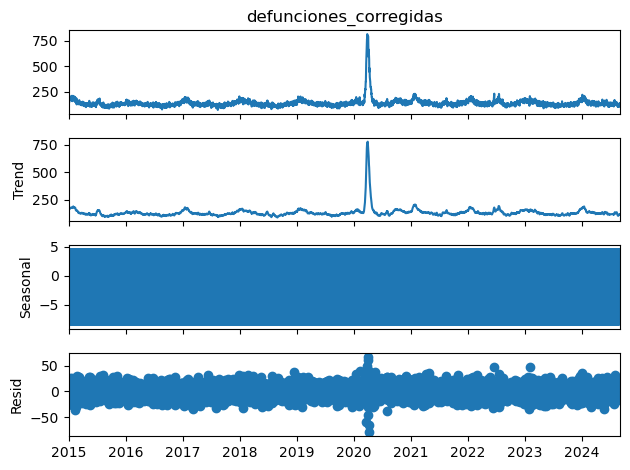

In [10]:
# Descomposición de la serie temporal (solo defunciones)
decomposed_defunciones_sin_exogenas = sm.tsa.seasonal_decompose(defunciones_temperaturas_madrid_df['defunciones_corregidas'], model='additive')
decomposed_defunciones_sin_exogenas.plot()
plt.show()

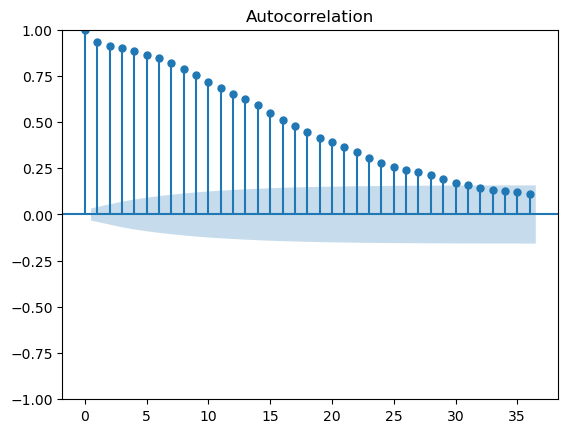

In [11]:
# Graficar autocorrelación para la serie de defunciones corregidas (sin exógenas)
plot_acf(defunciones_temperaturas_madrid_df['defunciones_corregidas'])
plt.show()

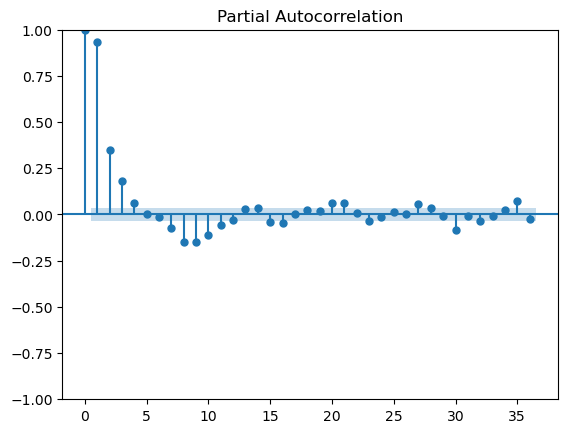

In [12]:
# Graficar autocorrelación parcial para la serie de defunciones corregidas (sin exógenas)
plot_pacf(defunciones_temperaturas_madrid_df['defunciones_corregidas'])
plt.show()

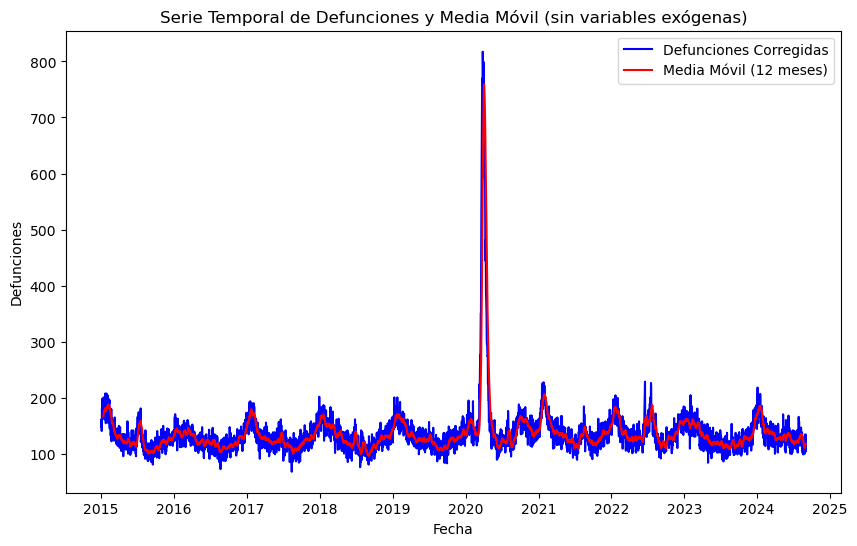

In [13]:
# Calcular media móvil (solo defunciones)
defunciones_temperaturas_madrid_df['defunciones_rolling'] = defunciones_temperaturas_madrid_df['defunciones_corregidas'].rolling(window=12).mean()

# Graficar defunciones corregidas y su media móvil
plt.figure(figsize=(10, 6))
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['defunciones_corregidas'], label='Defunciones Corregidas', color='blue')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['defunciones_rolling'], label='Media Móvil (12 meses)', color='red')
plt.title('Serie Temporal de Defunciones y Media Móvil (sin variables exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones')
plt.legend()
plt.show()

---

## **3. Análisis Exploratorio de la Serie Temporal (Con Variables Exógenas)**
A continuación, se grafican las variables exógenas (temperaturas) y se calculan las autocorrelaciones y las correlaciones entre las variables.

In [14]:
# Graficar las defunciones corregidas y temperaturas
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

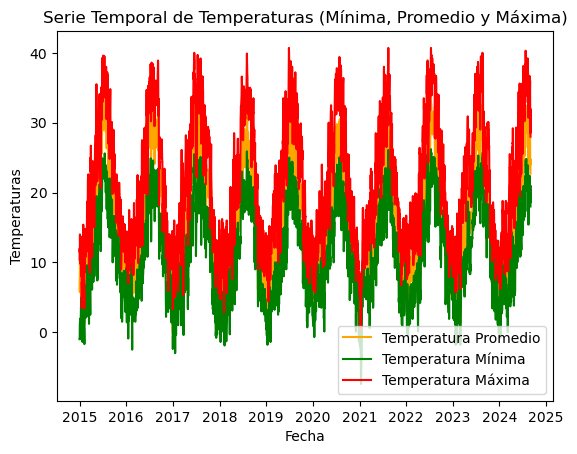

In [15]:
# Graficar la temperatura promedio
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tavg'], color='orange', label='Temperatura Promedio')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tmin'], color='green', label='Temperatura Mínima')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tmax'], color='red', label='Temperatura Máxima')

plt.title('Serie Temporal de Temperaturas (Mínima, Promedio y Máxima)')
plt.xlabel('Fecha')
plt.ylabel('Temperaturas')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

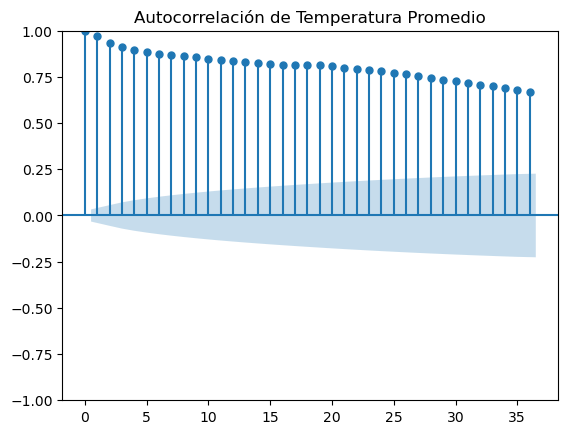

In [16]:
# Graficar autocorrelación de la temperatura promedio
plt.figure(figsize=(10, 6))
plot_acf(defunciones_temperaturas_madrid_df['tavg'], title='Autocorrelación de Temperatura Promedio')
plt.show()

<Figure size 1000x600 with 0 Axes>

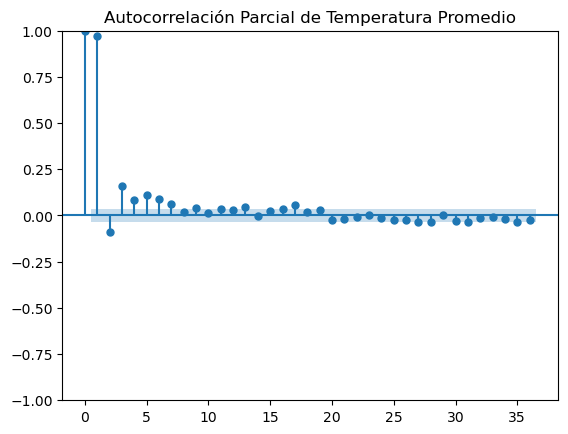

In [17]:
# Autocorrelación parcial para la temperatura promedio
plt.figure(figsize=(10, 6))
plot_pacf(defunciones_temperaturas_madrid_df['tavg'], title='Autocorrelación Parcial de Temperatura Promedio')
plt.show()

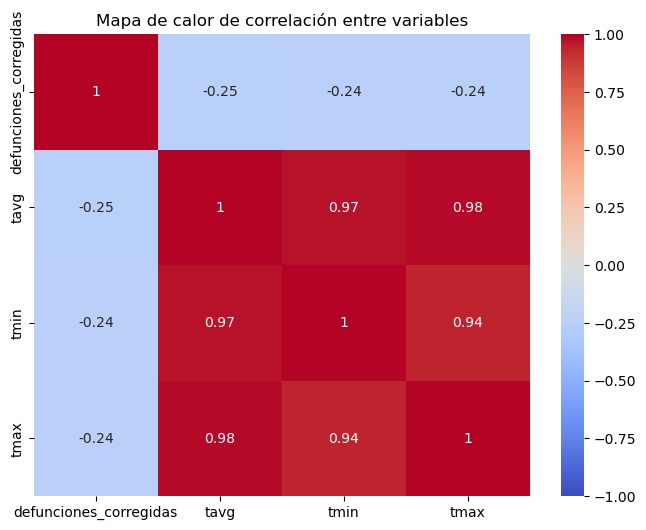

In [18]:
# Calcular la matriz de correlación entre defunciones y temperaturas
correlation_matrix = defunciones_temperaturas_madrid_df[['defunciones_corregidas', 'tavg', 'tmin', 'tmax']].corr()

# Graficar el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación entre variables')
plt.show()

---

## **4. Separación de Datos en Entrenamiento y Prueba (Sin Variables Exógenas)**
Dividimos los datos de **defunciones corregidas** en un 80% para el conjunto de **entrenamiento** y un 20% para el conjunto de **prueba** usando `train_test_split` de **sklearn**. No se utilizan variables exógenas en este paso, lo que significa que el modelo solo utilizará la serie de defunciones para hacer predicciones.

In [19]:
# Seleccionar la variable objetivo (defunciones corregidas)
y = defunciones_temperaturas_madrid_df['defunciones_corregidas']

# Dividir los datos en entrenamiento (80%) y prueba (20%) utilizando train_test_split
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

# Verificar las fechas de los conjuntos de entrenamiento y prueba
print(f"Fechas de entrenamiento: {y_train.index.min()} --- {y_train.index.max()}")
print(f"Fechas de prueba: {y_test.index.min()} --- {y_test.index.max()}")

Fechas de entrenamiento: 2015-01-01 00:00:00 --- 2022-09-24 00:00:00
Fechas de prueba: 2022-09-25 00:00:00 --- 2024-08-31 00:00:00


## **5. Primer Experimento: Predicción con ForecasterAutoreg (Sin Variables Exógenas)**
En este experimento, utilizamos **ForecasterAutoreg** con **RandomForestRegressor** para predecir la serie temporal de defunciones. Las predicciones se realizarán sobre el conjunto de prueba.

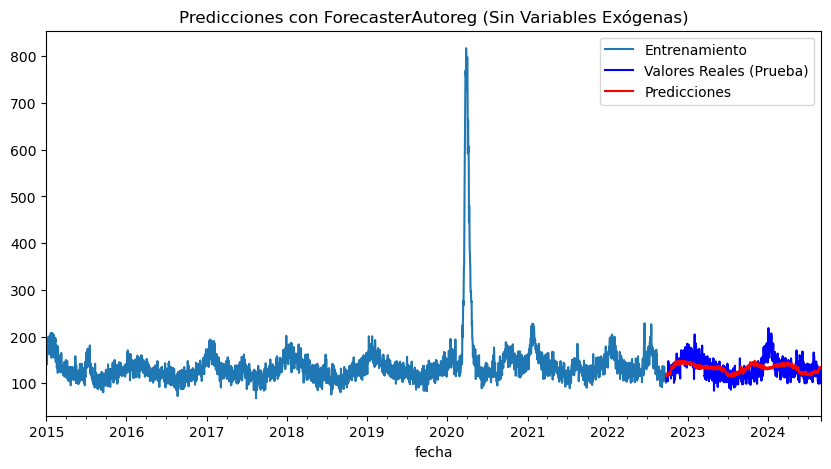

MAE original: 15.094719943422916
RMSE original: 19.546645455946678


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Crear y entrenar el forecaster con RandomForestRegressor
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 2000  # Número de lags usados como predictores
             )

# Entrenar el forecaster utilizando el conjunto de entrenamiento
forecaster.fit(y=y_train)

# Hacer predicciones para el conjunto de prueba
steps = len(y_test)  # Número de pasos a predecir
predicciones = forecaster.predict(steps=steps)

# Graficar las predicciones junto con el conjunto de prueba
fig, ax = plt.subplots(figsize=(10, 5))
y_train.plot(ax=ax, label='Entrenamiento')
y_test.plot(ax=ax, label='Valores Reales (Prueba)', color='blue')
predicciones.plot(ax=ax, label='Predicciones', color='red')
plt.title('Predicciones con ForecasterAutoreg (Sin Variables Exógenas)')
plt.legend()
plt.show()

# Calcular el MAE y RMSE para el modelo original
mae_original = mean_absolute_error(y_test, predicciones)
rmse_original = mean_squared_error(y_test, predicciones, squared=False)

print(f'MAE original: {mae_original}')
print(f'RMSE original: {rmse_original}')

## **6. Segundo Experimento: Optimización de ForecasterAutoreg con RandomForestRegressor (Sin Variables Exógenas)**

En este experimento mejorado, optimizamos el modelo **ForecasterAutoreg** ajustando los hiperparámetros de **RandomForestRegressor** y el número de lags utilizando validación cruzada. Esto nos permitirá mejorar las predicciones de la serie temporal de defunciones sobre el conjunto de prueba.

In [21]:
# Definir el forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 200  # Lags iniciales, probamos con 24 horas (1 día)
             )

# Hiperparámetros a ajustar
param_grid = {
    'n_estimators': [100, 200, 500],  # Más opciones de número de estimadores
    'max_depth': [5, 10, 20],         # Mayor rango de profundidades
    'min_samples_leaf': [1, 2, 4]     # Mayor rango de muestras por hoja
}

lags_grid = [10, 20, 50, 100, 300, 500]

# Búsqueda de hiperparámetros y número óptimo de lags con validación cruzada en serie temporal
results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = y_train, 
    param_grid         = param_grid,
    lags_grid          = lags_grid,  # Probaremos lags desde 10 hasta 50
    steps              = 20,  # Número de pasos para predecir en cada validación
    metric             = 'mean_absolute_error',
    refit              = False,
    initial_train_size = int(len(y_train) * 0.8),  # Tamaño del conjunto de entrenamiento para cada iteración
    fixed_train_size   = False,
    verbose            = False
)

Number of models compared: 162.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
  Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 500}
  Backtesting metric: 13.872994321304267



In [22]:
results_grid

,lags,lags_label,params,mean_absolute_error,max_depth,min_samples_leaf,n_estimators
80,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'min_samples_leaf': 4, 'n_es...",13.872994,20,4,500
78,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'min_samples_leaf': 4, 'n_es...",13.887585,20,4,100
106,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'min_samples_leaf': 4, 'n_es...",13.908959,20,4,200
105,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'min_samples_leaf': 4, 'n_es...",13.919386,20,4,100
79,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'min_samples_leaf': 4, 'n_es...",13.929928,20,4,200
...,...,...,...,...,...,...,...
110,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",16.488210,5,1,500
113,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",16.489129,5,2,500
115,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",16.503799,5,4,200
109,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",16.505095,5,1,200


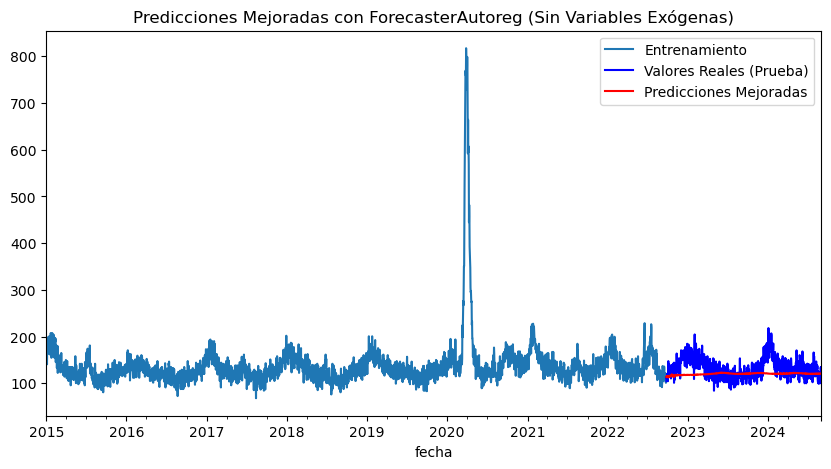

MAE mejorado: 19.021215742146683
RMSE mejorado: 25.23824393954653


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# Seleccionar la fila con el menor valor de mean_absolute_error
best_row = results_grid.loc[results_grid['mean_absolute_error'].idxmin()]

# Obtener los mejores parámetros y el número de lags
best_params = best_row['params']
best_lags = best_row['lags']

# Reentrenar el modelo con los mejores parámetros
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(
        n_estimators=best_params['n_estimators'], 
        max_depth=best_params['max_depth'], 
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=123
    ),
    lags = best_lags
)

# Entrenar el forecaster con los mejores hiperparámetros y lags
forecaster.fit(y=y_train)

# Predecir con el conjunto de prueba
steps = len(y_test)
predicciones_mejoradas = forecaster.predict(steps=steps)

# Graficar las predicciones mejoradas junto con el conjunto de prueba
fig, ax = plt.subplots(figsize=(10, 5))
y_train.plot(ax=ax, label='Entrenamiento')
y_test.plot(ax=ax, label='Valores Reales (Prueba)', color='blue')
predicciones_mejoradas.plot(ax=ax, label='Predicciones Mejoradas', color='red')
plt.title('Predicciones Mejoradas con ForecasterAutoreg (Sin Variables Exógenas)')
plt.legend()
plt.show()

# Calcular las métricas de error para el modelo mejorado
mae_mejorado = mean_absolute_error(y_test, predicciones_mejoradas)
rmse_mejorado = mean_squared_error(y_test, predicciones_mejoradas, squared=False)

print(f'MAE mejorado: {mae_mejorado}')
print(f'RMSE mejorado: {rmse_mejorado}')

## **7. Tercer Experimento: Predicción con ARIMA (Sin Variables Exógenas)**
En este experimento, utilizaremos el modelo **ARIMA** para predecir la serie temporal de defunciones sin usar variables exógenas. ARIMA es un modelo comúnmente utilizado para el análisis y predicción de series temporales.

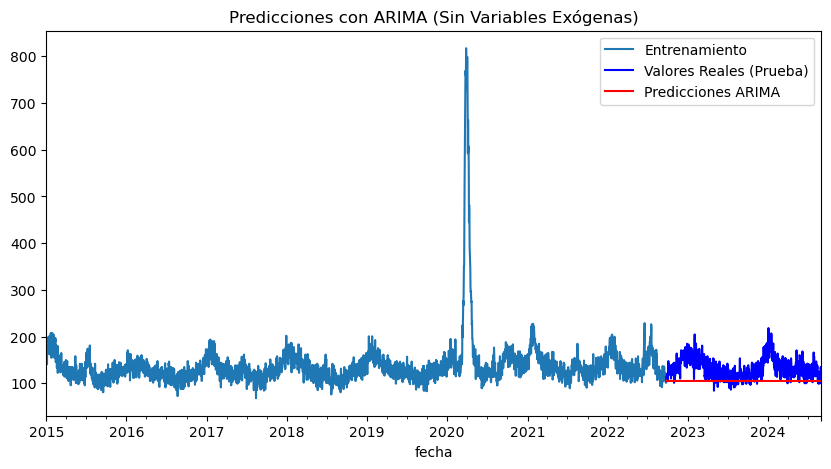

In [24]:
# Definir el modelo ARIMA
# Los parámetros p, d, q pueden ajustarse según los resultados previos de autocorrelación y pruebas
model_arima = ARIMA(y_train, order=(5, 1, 0))  # Ajustar los valores de p, d, q según corresponda

# Entrenar el modelo ARIMA
results_arima = model_arima.fit()

# Hacer predicciones para el conjunto de prueba
steps = len(y_test)
forecast_arima = results_arima.forecast(steps=steps)

# Asignar el índice temporal correcto a las predicciones
forecast_arima = pd.Series(data=forecast_arima, index=y_test.index)

# Graficar las predicciones junto con el conjunto de prueba
fig, ax = plt.subplots(figsize=(10, 5))
y_train.plot(ax=ax, label='Entrenamiento')
y_test.plot(ax=ax, label='Valores Reales (Prueba)', color='blue')
forecast_arima.plot(ax=ax, label='Predicciones ARIMA', color='red')
plt.title('Predicciones con ARIMA (Sin Variables Exógenas)')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular las métricas de error
mae_arima = mean_absolute_error(y_test, forecast_arima)
rmse_arima = mean_squared_error(y_test, forecast_arima, squared=False)

# Imprimir los resultados
print(f"MAE ARIMA: {mae_arima}")
print(f"RMSE ARIMA: {rmse_arima}")

MAE ARIMA: 28.834253843605484
RMSE ARIMA: 35.20798665642619


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
